In [1]:
# """ Mount Google Drive to Google Colab Notebook
# """ 
# from google.colab import drive
# drive.mount('/content/drive')
# """ Change present working directory
# """
# %cd /content/drive/MyDrive/CS5260/Github/

In [2]:
# %cd CS5260
!ls

Assignments
CS5260Project.ipynb
CS5260Project_new.ipynb
Colossalai_lr_range_benchmark
QA.txt
assets
data
drive-download-20220329T232318Z-001.zip
explore.py
logs
proposals
setup.sh
src


In [1]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch
import json
import os
import nltk
import random
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader

In [3]:
with open('./data/vaild_dataset.json', 'r') as outfile:
  product_info = pd.read_json(json.load(outfile), orient="records")
print(product_info.shape)
product_info.head()

(7331, 5)


,title,imageURLHighRes,description,perCategory,valid
0,14k Yellow Gold 3mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,"[With its smooth surface and high polish, this...",AMAZON_FASHION,True
1,14k Gold 4mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,"[With its smooth surface and high polish, this...",AMAZON_FASHION,True
2,18k Yellow Gold 7mm Comfort Fit Milgrain Plain...,https://images-na.ssl-images-amazon.com/images...,"[With its smooth surface and high polish, this...",AMAZON_FASHION,True
3,Sterling Silver Gold Plated Blue Topaz Earrings,https://images-na.ssl-images-amazon.com/images...,[Gemstone Specifications: Number of Stones - 2...,AMAZON_FASHION,True
4,Kenneth Cole_Watch Watch KC3489,https://images-na.ssl-images-amazon.com/images...,"[Dynamic Kenneth Cole style... modern, contemp...",AMAZON_FASHION,True


In [4]:
product_info["perCategory"].unique()

array(['AMAZON_FASHION', 'All_Beauty', 'Appliances',
       'Arts_Crafts_and_Sewing', 'Automotive', 'Books', 'CDs_and_Vinyl',
       'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry',
       'Digital_Music', 'Electronics', 'Gift_Cards',
       'Grocery_and_Gourmet_Food', 'Home_and_Kitchen',
       'Industrial_and_Scientific', 'Luxury_Beauty',
       'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments',
       'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies',
       'Prime_Pantry', 'Software', 'Sports_and_Outdoors',
       'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games'],
      dtype=object)

In [5]:
import re
def get_space_len(s):
  return len(max(re.findall(' +', s), key=len, default=[0]))

In [6]:
product_info = product_info[product_info.valid == True]
product_info = product_info[product_info["perCategory"].isin(["AMAZON_FASHION", 'All_Beauty',
                                                               'Toys_and_Games','Office_Products',
                                                              'Home_and_Kitchen','Electronics',
                                                              'Clothing_Shoes_and_Jewelry'])]
product_info["file_name"] = product_info["imageURLHighRes"].str.split("/").str[-1]

product_info = product_info.explode("description")
product_info["description"] = product_info["description"].str.split(".")
product_info = product_info.explode("description")
product_info = product_info.where(
    (product_info["description"].str.len()>5) & 
    (product_info["description"].astype(str).apply(get_space_len)<4)).dropna().reset_index(drop=True)
product_info['sentence_index'] = product_info.groupby('file_name').cumcount()  # Enumerate Groups
product_info = product_info[product_info['sentence_index'] <= product_info["description"].str.len().min()].reset_index(drop=True)
print(product_info.shape)
product_info.head(5)

(6785, 7)


,title,imageURLHighRes,description,perCategory,valid,file_name,sentence_index
0,14k Yellow Gold 3mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,"With its smooth surface and high polish, this ...",AMAZON_FASHION,True,41WGCY65ENL.jpg,0
1,14k Yellow Gold 3mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,The width of the ring is slightly rounded and...,AMAZON_FASHION,True,41WGCY65ENL.jpg,1
2,14k Yellow Gold 3mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,The eye-catching 14k gold color will attract ...,AMAZON_FASHION,True,41WGCY65ENL.jpg,2
3,14k Yellow Gold 3mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,Discover the Amazon Curated Collection of fine...,AMAZON_FASHION,True,41WGCY65ENL.jpg,3
4,14k Yellow Gold 3mm Half Round Plain Wedding Band,https://images-na.ssl-images-amazon.com/images...,The expansive selection of high-quality jewel...,AMAZON_FASHION,True,41WGCY65ENL.jpg,4


 The width of the ring is slightly rounded and the edges are straight, making the band appear more substantial while allowing it to sit comfortably
https://images-na.ssl-images-amazon.com/images/I/31ZCFMXJ8SL.jpg
AMAZON_FASHION


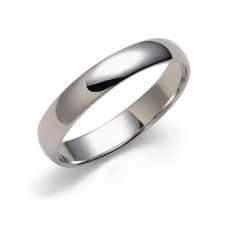

In [7]:
idex = random.randint(0, product_info.shape[0])
img_url = product_info.loc[idex,"imageURLHighRes"]
caption = product_info.loc[idex,"description"]
Category = product_info.loc[idex,"perCategory"]
print(caption)
print(img_url)
print(Category)
I = io.imread(img_url)
plt.axis('off')
plt.imshow(I)
plt.show()

In [8]:
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder

image_dict = product_info["imageURLHighRes"].to_dict()
caption_dict = product_info["description"].to_dict()
category_dict = product_info["perCategory"].to_dict()
onehot_cat = OneHotEncoder().fit_transform(np.array([*category_dict.values()], dtype=object).reshape(-1, 1)).toarray()
sentence_id_dict = product_info["sentence_index"].to_dict()
onehot_seq = OneHotEncoder().fit_transform(np.array([*sentence_id_dict.values()], dtype=object).reshape(-1, 1)).toarray()
one_hot = np.concatenate((onehot_cat, onehot_seq), axis=1)
print(one_hot.shape)

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
])

# Set the minimum word count threshold.
vocab_threshold = 5

mode = "train"

# Specify the batch size.
# we will pass 10 images at a time. So, m = 10
batch_size = 10

(6785, 14)


In [9]:
%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
data_loader = get_loader(product_info,
                        transform=transform_train,
                        mode='train',
                        image_type="imageURLHighRes",
                        caption_type="description",
                        batch_size=batch_size,
                        vocab_threshold=vocab_threshold,
                        vocab_from_file=False)

print('The shape of first image:', data_loader.dataset[0][0].shape)
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, onehot_cat, onehot_enc_seq, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('onehot_cat.shape:', onehot_cat.shape)
print('captions.shape:', captions.shape)

[0/6785] Tokenizing captions...
Obtaining caption lengths...


100%|██████████| 6785/6785 [00:00<00:00, 8798.98it/s]


The shape of first image: torch.Size([3, 320, 320])
Total number of tokens in vocabulary: 3677
sampled indices: [2421, 5527, 2934, 1926, 2441, 6662, 564, 5209, 6314, 3856]
images.shape: torch.Size([10, 3, 320, 320])
onehot_cat.shape: torch.Size([10, 1, 7])
captions.shape: torch.Size([10, 16])


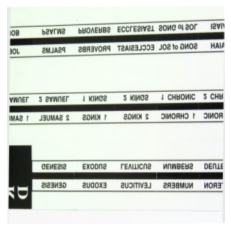

In [11]:
plt.axis('off')
plt.imshow(images[0].detach().T)
plt.show()

# Training Setup 

In [12]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import sys
import os
import math
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')

%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader
from src.models.CNN_Encoder import EncoderCNN
from src.models.RNN_decoder_catAttention import DecoderRNN
from src.models.MLP_Encoder import MlpEncoder
from src.utils.utils_trainer import get_batch_caps, get_hypothesis, adjust_learning_rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Training Model

In [29]:
def train(epoch, 
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion, 
          total_step, 
          num_epochs, 
          data_loader, 
          write_file, 
          save_every = 1):
    """ Train function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder
    - decoder - model's Decoder
    - optimizer - model's optimizer (Adam in our case)
    - criterion - loss function to optimize
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the training logs
    
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    
    for i_step in range(1, total_step+1):
        # training mode on
        encoder.train() # no fine-tuning for Encoder
        # mlp.train()
        decoder.train()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, onehot_cat, onehot_seq, captions = next(iter(data_loader))
        # target captions, excluding the first word
        captions_target = captions[:, 1:].to(device) 
        # captions for training without the last word
        captions_train = captions[:, :-1].to(device)

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)

        onehot_cat = torch.cat((onehot_cat.view(batch_size,-1), 
                                onehot_seq.view(batch_size,-1)), 1).type('torch.FloatTensor').view(batch_size,-1).to(device)
        # Zero the gradients.
        decoder.zero_grad()
        # mlp.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)

        outputs, atten_weights = decoder(captions= captions_train,
                                         features = features,
                                         category_enc = onehot_cat)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size).to(device), captions_target.reshape(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex
        
        stats = 'Epoch train: [%d/%d], Step train: [%d/%d], Loss train: %.4f, Perplexity train: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), perplex)
        
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
        
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    
    print('\r')
    print('Epoch train:', epoch)
    print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
    print('\r')

In [30]:
def validate(epoch, 
             encoder, 
             decoder, 
             encoder_optimizer, 
             decoder_optimizer, 
             criterion, 
             total_step, num_epochs, data_loader, write_file, bleu_score_file):
    """ Validation function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder (evaluation)
    - decoder - model's Decoder (evaluation)
    - optimizer - model's optimizer (Adam in our case)
    - criterion - optimized loss function
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the validation logs
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    references = []
    hypothesis = []
      
    for i_step in range(1, total_step+1):
        # evaluation of encoder and decoder
        encoder.eval()
        decoder.eval()
        val_images, val_onehot_cat, val_onehot_seq, val_captions, caps_all = next(iter(data_loader))
        
        val_captions_target = val_captions[:, 1:].to(device) 
        val_captions = val_captions[:, :-1].to(device)
        val_images = val_images.to(device)
       
        val_onehot_cat = torch.cat((val_onehot_cat.view(batch_size,-1), 
                                    val_onehot_seq.view(batch_size,-1)), 1).type('torch.FloatTensor').view(batch_size,-1).to(device)
        
        features_val = encoder(val_images)
        outputs_val, atten_weights_val = decoder(captions= val_captions,
                                                 features = features_val,
                                                 category_enc=val_onehot_cat)
        loss_val = criterion(outputs_val.view(-1, vocab_size), 
                             val_captions_target.reshape(-1))
        
        # preprocess captions and add them to the list
        caps_processed = get_batch_caps(caps_all, batch_size=batch_size)
        references.append(caps_processed)
        # get corresponding indicies from predictions
        # and form hypothesis from output
        terms_idx = torch.max(outputs_val, dim=2)[1]
        hyp_list = get_hypothesis(terms_idx, data_loader=data_loader)
        hypothesis.append(hyp_list)
        
        perplex = np.exp(loss_val.item())
        epoch_loss += loss_val.item()
        epoch_perplex += perplex
        
        stats = 'Epoch valid: [%d/%d], Step valid: [%d/%d], Loss valid: %.4f, Perplexity valid: %5.4f' % (epoch, num_epochs, i_step, total_step, loss_val.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
            
    # prepare the proper shape for computing BLEU scores
    references = np.array(references).reshape(total_step*batch_size, -1)
    #hyps = np.array(hypothesis).reshape(total_step*batch_size, -1)
    hyps = np.concatenate(np.array(hypothesis))
        
    bleu_1 = corpus_bleu(references, hyps, weights = (1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hyps, weights = (0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hyps, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
    bleu_4 = corpus_bleu(references, hyps, weights = (0.25, 0.25, 0.25, 0.25))
    # append individual n_gram scores
    #bleu_score_list.append((bleu_1, bleu_2, bleu_3, bleu_4))
    
    print('\r')
    print('Epoch valid:', epoch)
    epoch_stat = 'Avg. Loss valid: %.4f, Avg. Perplexity valid: %5.4f, \
    BLEU-1: %.2f, BLEU-2: %.2f, BLEU-3: %.2f, BLEU-4: %.2f' % (epoch_loss_avg, epoch_perp_avg, bleu_1, bleu_2, bleu_3, bleu_4)
    
    print('\r' + epoch_stat, end="")
    print('\r')
    
    bleu_score_file.write(epoch_stat + '\n')
    bleu_score_file.flush()
    return bleu_1, bleu_2, bleu_3, bleu_4

In [31]:
batch_size = 5          # batch size, change to 64
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 125           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
num_epochs = 200               # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

log_train = './logs/training_log.txt'       # name of files with saved training loss and perplexity
log_val = './logs/validation_log.txt'
bleu = './logs/bleu.txt'

In [32]:
train_df, val_test_df = train_test_split(product_info, test_size=0.4)
train_df.reset_index(drop=True,inplace=True)
valid_df, test_df = train_test_split(val_test_df, test_size=0.5)
valid_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)


# transform_train = transforms.Compose([ 
#     transforms.Resize(500),                          # smaller edge of image resized to 256
#     transforms.Resize((320,320)),                      # get 224x224 crop from random location
#     transforms.ToTensor(),                           # convert the PIL Image to a tensor
#     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
#                          (0.229, 0.224, 0.225))])
transform_train = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
])

# Build data loader.
data_loader = get_loader(train_df,
                         transform=transform_train,
                         mode='train',
                         image_type="imageURLHighRes",
                         caption_type="description",
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
])

# Create the data loader.

valid_data_loader = get_loader(valid_df,
                               transform=transform_test,
                               mode='valid',
                               image_type="imageURLHighRes",
                               caption_type="description",
                               batch_size=batch_size)


total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
total_step_valid

[0/4071] Tokenizing captions...
Obtaining caption lengths...


100%|██████████| 4071/4071 [00:00<00:00, 8596.83it/s]


Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 1357/1357 [00:00<00:00, 8811.55it/s]


272

In [33]:
# Initialize the encoder and decoder. 
#def __init__(self, num_features, embedding_dim, category_dim, hidden_dim, vocab_size, p =0.5, cat_attention=False):

encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     category_dim = len(set(category_dict.values())) + len(set(sentence_id_dict.values())) ,
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size,
                     cat_attention = True)


# Move models to GPU if CUDA is available. 
device = torch.device("cpu")
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embeddings): Embedding(2495, 125)
  (lstm): LSTMCell(2187, 512)
  (fc): Linear(in_features=512, out_features=2495, bias=True)
  (attention): TranslateAttention(
    (W_a): Linear(in_features=2062, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (init_h): Linear(in_features=2062, out_features=512, bias=True)
  (init_c): Linear(in_features=2062, out_features=512, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [34]:
print(device)
# Define the loss function. 
criterion = nn.CrossEntropyLoss()
criterion.to(device)
#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper

encoder_lr = 1e-3  # learning rate for encoder if fine-tuning
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),lr=encoder_lr)
encoder_lr_scheduler = torch.optim.lr_scheduler.CyclicLR(encoder_optimizer, 
                                                         base_lr=encoder_lr/10, max_lr=encoder_lr*10, 
                                                         step_size_up = 10 , step_size_down=20, cycle_momentum=False)


decoder_lr = 1e-3  # learning rate for decoder
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=decoder_lr)
decoder_lr_scheduler = torch.optim.lr_scheduler.CyclicLR(decoder_optimizer, 
                                                         base_lr=decoder_lr/10, max_lr=decoder_lr*10, 
                                                         step_size_up = 10 , step_size_down=20, cycle_momentum=False)

fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)


cpu


In [35]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M-%S")
if not os.path.exists(f'../models_new/{current_time}'):
  os.makedirs(f'../models_new/{current_time}')

# Open the training log file.
file_train = open(log_train, 'w')
file_val = open(log_val, 'w')
bleu_score_file = open(bleu, 'w')

# store BLEU scores in list 
bleu_scores = []
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
epochs_since_improvement = 0
best_bleu = 0.

for epoch in range(0, num_epochs+1):
    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 50:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 20 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    train(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, total_step, num_epochs =num_epochs,
          data_loader = data_loader,
          write_file = file_train, 
          save_every = 1)
    
    bleus= validate(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
                                             total_step = total_step_valid, 
                                             num_epochs = num_epochs, 
                                             data_loader = valid_data_loader, write_file=file_val, bleu_score_file=bleu_score_file)
    
    # encoder_lr_scheduler.step()
    # decoder_lr_scheduler.step()
    
    # Check if there was an improvement
    is_best = sum(bleus)/4 > best_bleu
    best_bleu = max(sum(bleus)/4, best_bleu)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        torch.save(decoder.state_dict(), os.path.join(f'../models_new/{current_time}', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join(f'../models_new/{current_time}', 'encoder-%d.pkl' % epoch))
        epochs_since_improvement = 0
    
file_train.close()
file_val.close()
bleu_score_file.close()

Epoch train: [0/200], Step train: [3/815], Loss train: 7.6778, Perplexity train: 2159.8900

KeyboardInterrupt: 

# Generate Predictions

In [21]:
# Setup the transforms
# transform_test = transforms.Compose([ 
#     transforms.Resize((320,320)),                          # smaller edge of image resized to 256
#     transforms.ToTensor(),                           # convert the PIL Image to a tensor
#     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
#                          (0.229, 0.224, 0.225))])

transform_test = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
])

In [22]:
test_data_loader = get_loader(test_df,
                              image_type="imageURLHighRes",
                              caption_type="description",
                              transform=transform_test,
                              batch_size=1,
                              mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [26]:
encoder_file = 'encoder-4.pkl' 
decoder_file = 'decoder-4.pkl'

embed_size = 125           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder

# The size of the vocabulary.
vocab_size = 3633#len(test_data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN()
encoder.eval()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size,
                     category_dim = len(set(category_dict.values())) + len(set(sentence_id_dict.values())),
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)
decoder.eval()

current_time = "2022-03-31-16-43-01"
# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join(f'../models_new/{current_time}', encoder_file), map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join(f'../models_new/{current_time}', decoder_file), map_location='cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embeddings): Embedding(3633, 125)
  (lstm): LSTMCell(2191, 512)
  (fc): Linear(in_features=512, out_features=3633, bias=True)
  (attention): TranslateAttention(
    (W_a): Linear(in_features=2048, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

In [38]:
def clean_sentence(output, data_loader):
    vocab = data_loader.dataset.vocab.idx2word
    words = [vocab.get(idx) for idx in output]
    words = [word for word in words if word not in (',', '.', '<end>')]
    sentence = " ".join(words)
    
    return sentence

def get_prediction(data_loader):
    orig_image, image, cat_onehot, seq_onehot, caption= next(iter(data_loader))
    plt.imshow(orig_image.squeeze())
    print(cat_onehot.size())
    plt.title(caption)
    plt.show()
    image = image.to(device)
    onehot = torch.cat((cat_onehot.view(1,-1), 
                            seq_onehot.view(1,-1)), 1).type('torch.FloatTensor').view(1,-1).to(device)
    
    features = encoder(image)
    output, atten_weights = decoder.greedy_search(features, onehot)    
    sentence = clean_sentence(output,data_loader)
    print(sentence)

torch.Size([1, 1, 11])


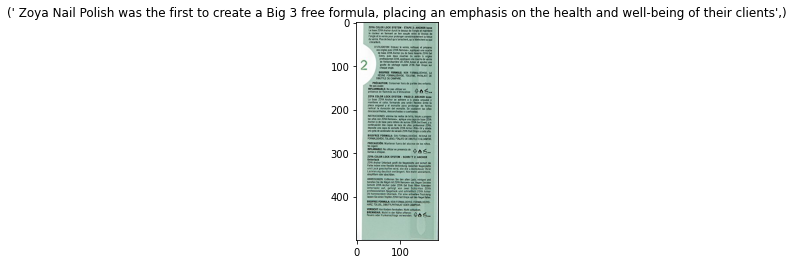

<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [44]:
get_prediction(test_data_loader)